In [46]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#pandas and matplotlib warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [30]:
#getting data
disease_type = 'ILI'
year_range='2017-2020'
path_to_data = 'data/NYC_'+disease_type+'_'+year_range+'.csv'
df = pd.read_csv(path_to_data,infer_datetime_format=True,encoding='latin')
df.tail()

,Data note 1,Ind1Name,Dim1Name,Dim1Value,Dim2Name,Dim2Value,Date,Count
41225,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,Ages 65+ years,3/19/2020,153
41226,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,Ages 65+ years,3/20/2020,177
41227,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,Ages 65+ years,3/21/2020,163
41228,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,Ages 65+ years,3/22/2020,140
41229,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,Ages 65+ years,3/23/2020,167


In [31]:
#getting 2020 data
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df[(df['Date']>='2020-01-01')] #df is 2020 data
df["Count"] = pd.to_numeric(df['Count'].str.replace(",",""))
# add day of week
df['Day of Week'] = df['Date'].dt.weekday
df = df.reset_index(drop=True)
#only consider citywide, all age groups
df = df[(df['Dim1Value']=='Citywide')&(df['Dim2Value']=='All age groups')]

In [32]:
print(df.shape)
df.head()

(83, 9)


,Data note 1,Ind1Name,Dim1Name,Dim1Value,Dim2Name,Dim2Value,Date,Count,Day of Week
2490,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,All age groups,2020-01-01,884,2
2491,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,All age groups,2020-01-02,941,3
2492,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,All age groups,2020-01-03,895,4
2493,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,All age groups,2020-01-04,887,5
2494,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Citywide,Citywide,Age Group,All age groups,2020-01-05,836,6


In [33]:
#loading baselines from data folder
baseline_path = "data/baseline_percentiles_2017-2019_mostrecent2wks_"+disease_type+".pkl"
baseline = pd.read_pickle(baseline_path)
baseline.head()

0.5,mean,20%,80%
Day of Week,,,
0,308.5,263.0,318.0
1,284.5,254.0,321.0
2,272.0,209.0,317.0
3,230.0,227.6,286.4
4,278.0,226.6,282.4


In [34]:
#notice this is an inplace operation
def subtract_baseline(data:pd.DataFrame,baseline:pd.DataFrame,percentile_key:str):
    #percentile key is the column name in baseline used to subtract off data 
    #a terribly inefficient implementation
    normalized_count = []
    for index, row in df.iterrows():
        normalized_count.append(row['Count'] - baseline.loc[int(row['Day of Week']),percentile_key])
    data['Normalized Count '+percentile_key+' baseline'] = normalized_count
    return data

In [35]:
new_df = subtract_baseline(df,baseline, "mean")
new_df = subtract_baseline(df,baseline, "20%")
new_df = subtract_baseline(df,baseline, "80%")

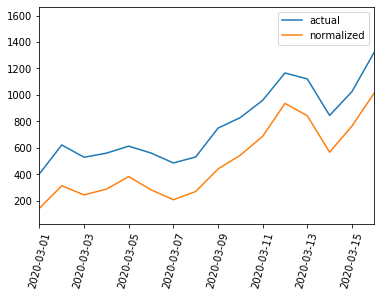

In [39]:
plt.plot(new_df['Date'],new_df['Count'],label='actual')
plt.plot(new_df['Date'],new_df['Normalized Count mean baseline'],label='normalized')
plt.legend()
plt.xlim(('2020-03-01', '2020-03-16'))
plt.xticks(rotation=75);

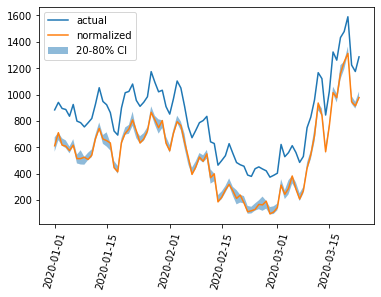

In [37]:
plt.plot(new_df['Date'],new_df['Count'],label='actual')
plt.plot(new_df['Date'],new_df['Normalized Count mean baseline'],label='normalized')
plt.fill_between(new_df['Date'],y1=new_df['Normalized Count 80% baseline'],y2=new_df['Normalized Count 20% baseline'],label='20-80% CI',alpha=0.5)
plt.legend()
plt.xticks(rotation=75);

In [67]:
days_to_hospitalization = np.arange(10, 14 + 1)
growth_rate = np.arange(0.15, 0.42, 0.05)
peak_demand_multiplier = np.exp(np.log(1+growth_rate)[:,np.newaxis].dot(days_to_hospitalization[np.newaxis, :]))

In [68]:
peak_demand_multiplier

array([[  4.04555774,   4.6523914 ,   5.35025011,   6.15278762,
          7.07570576],
       [  6.19173642,   7.43008371,   8.91610045,  10.69932054,
         12.83918465],
       [  9.31322575,  11.64153218,  14.55191523,  18.18989404,
         22.73736754],
       [ 13.78584918,  17.92160394,  23.29808512,  30.28751066,
         39.37376386],
       [ 20.10655587,  27.14385042,  36.64419807,  49.4696674 ,
         66.78405098],
       [ 28.9254655 ,  40.4956517 ,  56.69391238,  79.37147733,
        111.12006826]])

In [69]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

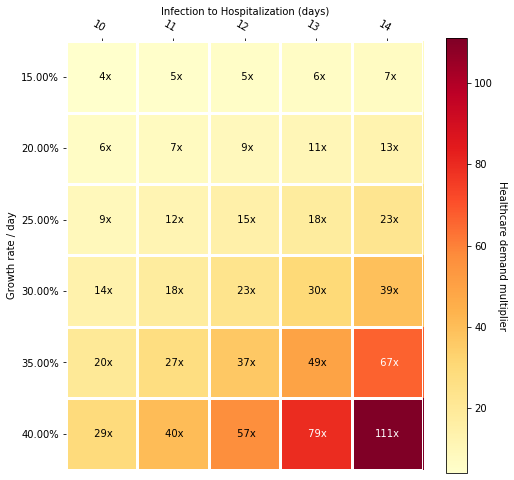

In [70]:
fig, ax = plt.subplots()

fig.set_size_inches(8, 8)

im, cbar = heatmap(peak_demand_multiplier, ["{:.2f}%".format(gr * 100) for gr in growth_rate], days_to_hospitalization, ax=ax,
                   cmap="YlOrRd", cbarlabel="Healthcare demand multiplier")
texts = annotate_heatmap(im, valfmt="{x:3.0f}x")
ax.set_ylabel("Growth rate / day")
ax.set_xlabel("Infection to Hospitalization (days)")
ax.xaxis.set_label_position('top') 

#fig.tight_layout()
plt.show()